## Looking at gradient heatmaps of data scaled models

In [33]:
# helper functions :)
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
plt.rcParams["font.family"] = "Times New Roman"

obs_dim = 2
def sample_gradient_images(agent,config):
    agent.eval()

    fix_mask = agent.fix_mask
    fix_mask = fix_mask * 0.0
    fix_mask[:,0, :] = 1. # for the starting/current state
    agent.fix_mask = fix_mask # for ending state
    state_history = [[[-0.96 , 0.96]]]
    history_len = min(len(state_history),config.memory)
    state_history_array = torch.tensor(np.array(state_history),device=config.device) # shape (len(state_history), n_envs, obs_dim)
    state_history_array = state_history_array[-history_len:] # shape (history_len,n_envs,obs_dim)
    state_history_array = torch.transpose(state_history_array,0,1)
    prior = torch.zeros((config.num_envs, config.gen_horizon, obs_dim), device=config.device) # size (num_envs, config.horizon, obs_dim)

    prior[:, :history_len, :] = state_history_array#[:,-history_len:,:] # inpaints start state at beginning of trajectory


    traj, log = agent.sample(
        prior,
        solver='ddpm',
        n_samples=config.num_envs,
        sample_steps=config.sampling_steps,
        use_ema=config.use_ema, 
        w_cg=config.w_cg, 
        temperature=config.temperature,
        requires_grad=True,
        preserve_history=True)
    
    #print(log['grad_history'].shape)
    #fig, ax = plt.subplots(figsize=(6, 6),dpi=400)

    # should be shape ~500, ~100
    gradient_image = np.nan_to_num(np.abs(np.squeeze(log['grad_history'],(0,2))[1:,1:,0].T))
    return gradient_image
def plot_gradient_images(gradient_image,title=''):
    fig, ax = plt.subplots(dpi=400)
    plt.imshow(gradient_image,aspect=1/5,cmap=mpl.colormaps['cividis'])
    plt.title(title,size=27)
    #plt.colorbar()
    plt.xlabel('DDPM Step',size=27)
    plt.ylabel('Trajectory Gradient',size=27)
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=0,size=0)
    

In [2]:
# U-Net unconditional, full data

config = DiffusionPlannerConfig()
config.guidance = 'none'
config.num_episodes = 1
config.w_cfg = 1.0
config.num_envs = 1
obs_dim = 2
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
# --------------- Network Architecture -----------------
if config.use_shift_equivariant_arch:
    #nn_diffusion = ConvNext1dShiftEq(obs_dim)
    nn_diffusion = CNN1dShiftEq(obs_dim,
                                kernel_expansion_rate=config.kernel_expansion_rate,
                                model_dim = config.model_dim,
                                emb_dim = config.emb_dim,
                                encode_position = config.add_positional_encoding)
else:
    nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)


classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
    nn_condition = MLPCondition(
    in_dim=config.lang_enc_size, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
    nn_condition = None
loss_weight = torch.ones((config.gen_horizon, obs_dim))
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# loads agent
#agent.load('../data_scaling/trained_models/DP-UNet-Uncond-Full-decagon-2a272be8diffusion_ckpt_200000.pt')
agent.load('../data_scaling/trained_models/DP-UNet-Uncond-Small-decagon-c400557ediffusion_ckpt_200000.pt')

/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

In [3]:
models = ['../data_scaling/trained_models/DP-UNet-Uncond-Full-decagon-2a272be8diffusion_ckpt_200000.pt',
          '../data_scaling/trained_models/DP-UNet-Uncond-Medium-decagon-8822f635diffusion_ckpt_200000.pt',
          '../data_scaling/trained_models/DP-UNet-Uncond-SMM-decagon-e64cda3adiffusion_ckpt_200000.pt',
          '../data_scaling/trained_models/DP-UNet-Uncond-SM-decagon-f2faaa21diffusion_ckpt_200000.pt',
          '../data_scaling/trained_models/DP-UNet-Uncond-SSM-decagon-c590c495diffusion_ckpt_200000.pt',
          '../data_scaling/trained_models/DP-UNet-Uncond-Small-decagon-c400557ediffusion_ckpt_200000.pt']
grad_images = []
from tqdm import tqdm
for model in tqdm(models):
    agent.load(model)
    grad_image_unet = 0
    for i in range(25):
        grad_image_unet += sample_gradient_images(agent,config)
    grad_image_unet /= 25
    #plot_gradient_images(grad_image_unet,title='U-Net')
    grad_images.append(grad_image_unet)

100%|██████████| 6/6 [1:06:49<00:00, 668.31s/it]


In [42]:
plot_gradient_images(grad_images[6][:512,:],title='Small Data (250)')

IndexError: list index out of range

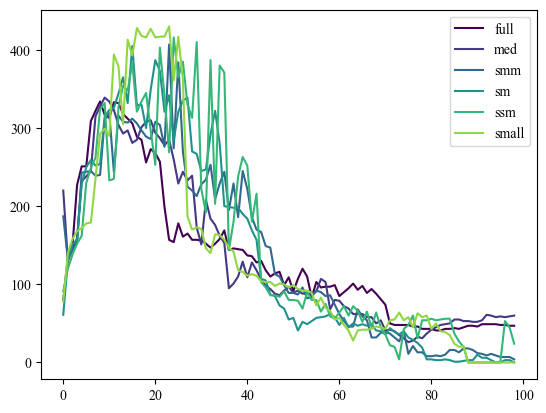

In [30]:
names = ['full','med','smm','sm','ssm','small']
percentile = 75
unet_windows = []
color_thing = mpl.colormaps['viridis']
for thing in grad_images:
    grad_image_unet = thing[:513,:]
    windows_unet = []
    #print(grad_image_unet.shape)
    for ddm_step_index in range(grad_image_unet.shape[1]-1):
        trajectory_gradient = grad_image_unet[:,ddm_step_index]
        sorted_gradients = np.sort(trajectory_gradient) # no does low to high
        #threshold_value = sorted_gradients[450] # this doesn't really make sense
        threshold_value = np.percentile(grad_image_unet.flatten(),percentile)
        low_index = 0
        high_index = 510
        found_low = False
        found_high = False
        # finds lowest value
        while not found_low:
            if trajectory_gradient[low_index] > threshold_value or low_index == 256:
                found_low = True
            else:
                low_index += 1

        while not found_high:
            if trajectory_gradient[high_index] > threshold_value or high_index ==  256:
                found_high = True
            else:
                high_index -= 1
        windows_unet.append(high_index-low_index)
    windows_unet = np.array(windows_unet)
    unet_windows.append(windows_unet)

for i,window in enumerate(unet_windows):
    plt.plot(window,label=names[i],c=color_thing(i/6))
plt.legend()

Text(0.5, 1.0, 'Training Data Size vs Receptive Field Size')

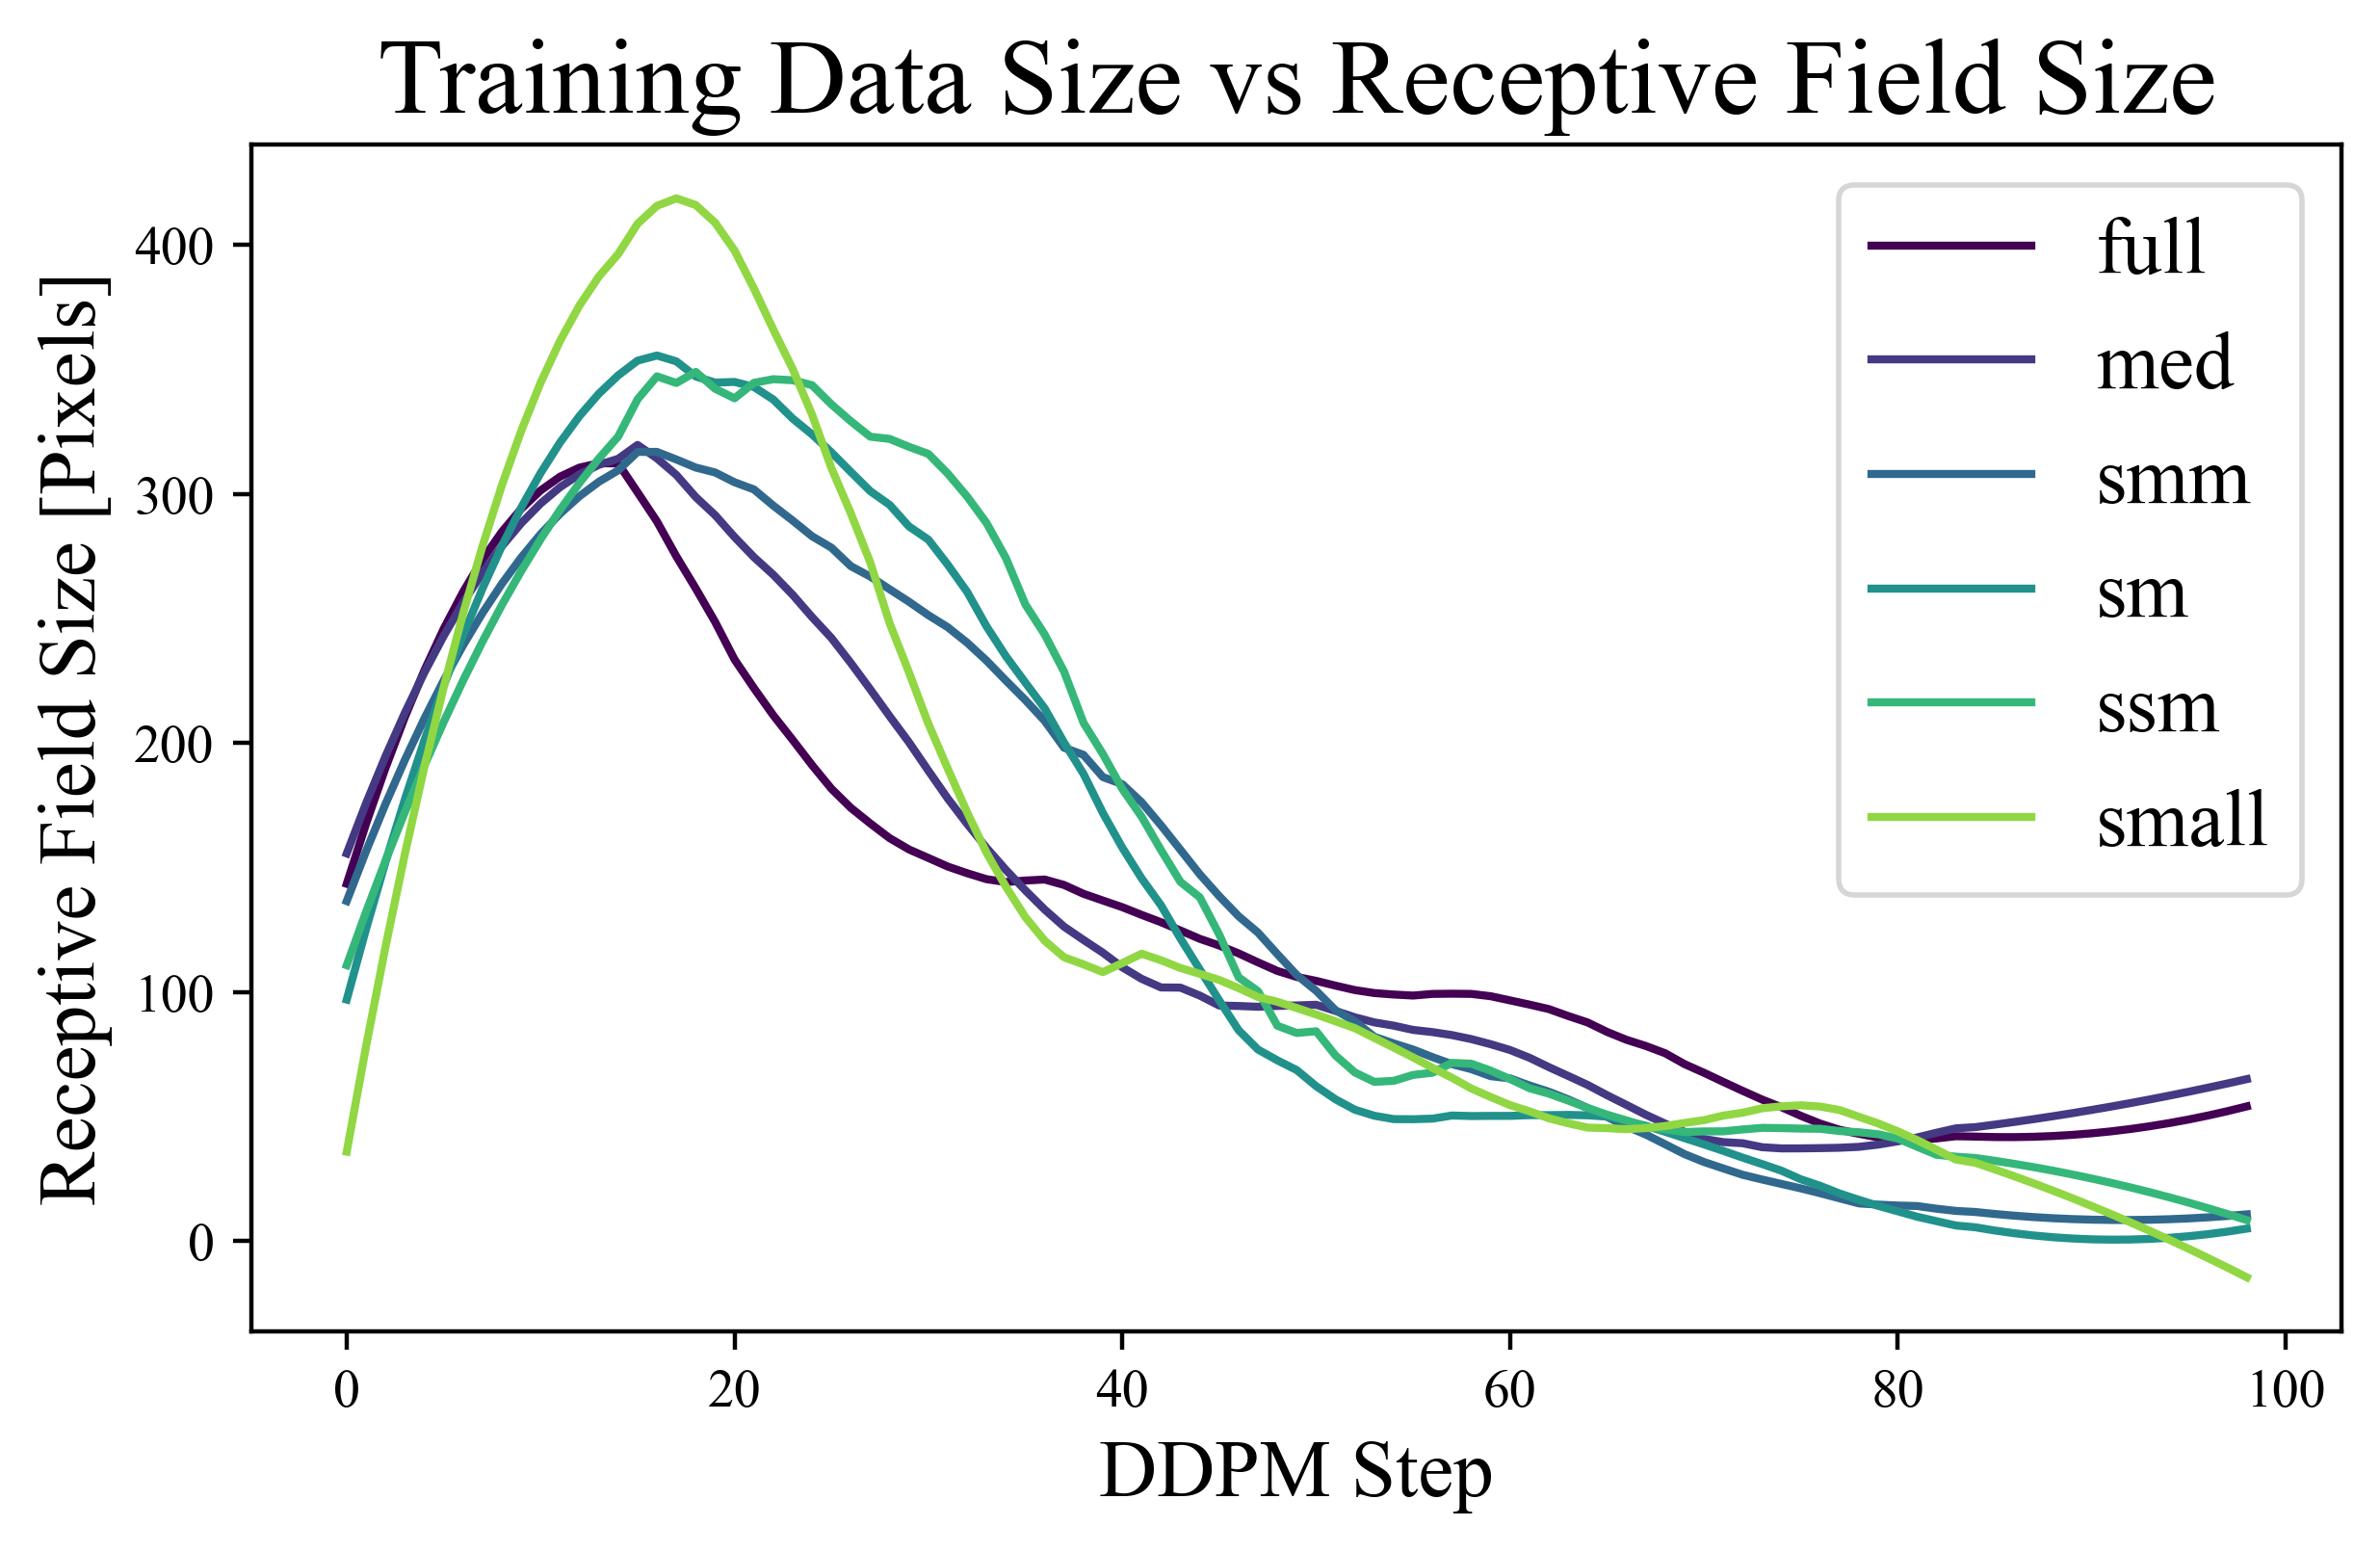

In [57]:
from scipy.signal import savgol_filter
fig, ax = plt.subplots(dpi=400,figsize=(7,4))

names = ['full','med','smm','sm','ssm','small']
percentile = 75
unet_windows = []
color_thing = mpl.colormaps['viridis']
for thing in grad_images:
    grad_image_unet = thing[:513,:]
    windows_unet = []
    #print(grad_image_unet.shape)
    for ddm_step_index in range(grad_image_unet.shape[1]-1):
        trajectory_gradient = grad_image_unet[:,ddm_step_index]
        sorted_gradients = np.sort(trajectory_gradient) # no does low to high
        #threshold_value = sorted_gradients[450] # this doesn't really make sense
        threshold_value = np.percentile(grad_image_unet.flatten(),percentile)
        low_index = 0
        high_index = 510
        found_low = False
        found_high = False
        # finds lowest value
        while not found_low:
            if trajectory_gradient[low_index] > threshold_value or low_index == 256:
                found_low = True
            else:
                low_index += 1

        while not found_high:
            if trajectory_gradient[high_index] > threshold_value or high_index ==  256:
                found_high = True
            else:
                high_index -= 1
        windows_unet.append(high_index-low_index)
    windows_unet = np.array(windows_unet)
    unet_windows.append(windows_unet)

for i,window in enumerate(unet_windows):
    smooth_window = savgol_filter(window, 30, 2)
    plt.plot(smooth_window,label=names[i],c=color_thing(i/6))
plt.legend(fontsize=15)

plt.ylabel('Receptive Field Size [Pixels]',size=15)
plt.xlabel('DDPM Step',size=15)
plt.title('Training Data Size vs Receptive Field Size',size=20)